# Imports

In [1]:
import numpy as np
import tensorflow as tf
from common.model import create_ssm, get_ssm_weights, set_ssm_weights
from common.data import generate_inputs, create_one_hot_array
from common.train import train

np.set_printoptions(linewidth=200)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[5:6], 'GPU')

2025-02-01 17:12:06.509634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 17:12:21.636994: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 17:12:21.641721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-02-01 17:12:21.715101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 17:12:21.715817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573

# Global variables

In [2]:
sd_baseline = 1
sd_special = 1
epochs = int(1e6)
log_period = 100
print_period = int(1e4)
n_evals = 7
epochs_after_opt = 1500

# Length = 6, teacher state dim = 4, student state dim = 10

## Shared setup

In [3]:
seed = 403
teacher_state_dim = 4
student_state_dim = 10
sd_A = 0.01
sd_B_C = 0.01
length = 6
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(2 * np.log10(1 / sd_A))

In [4]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
A[2, 2] = 0.5
A[3, 3] = 0.3
B[0, 0] = 1
B[0, 1] = 1
B[0, 2] = 1
B[0, 3] = 1
C[0, 0] = 1
C[1, 0] = 1
C[2, 0] = 1
C[3, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

2025-02-01 17:12:21.831617: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 17:12:21.833471: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 17:12:21.834388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 17:12:21.834439: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 17:12:21.834476: I tensorflow/stream_executor/

## 8 baseline inputs, 0 special inputs

In [5]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
title = 'SSM,\nwithout special sequences'

In [6]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

2025-02-01 17:12:22.937974: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2025-02-01 17:12:23.390606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-02-01 17:12:23.408271: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 3.9558963775634766
7 absolute largest EVs of A: [0.01007305 0.00915695 0.00914794 0.0091112  0.00608163 0.00419972 0.00381182]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10000
Train loss: 0.04670567065477371
7 absolute largest EVs of A: [1.067866   0.02407901 0.02391546 0.02327643 0.00769666 0.00463583 0.00412648]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 20000
Train loss: 0.04670534282922745
7 absolute largest EVs of A: [1.067866   0.02778294 0.02753343 0.02657378 0.00779843 0.00465912 0.00414045]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 30000
Train loss: 0.04670443758368492
7 absolute largest EVs of A: [1.0678657  0.03393296 0

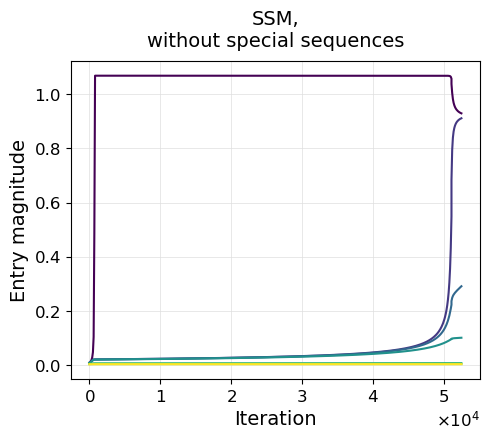

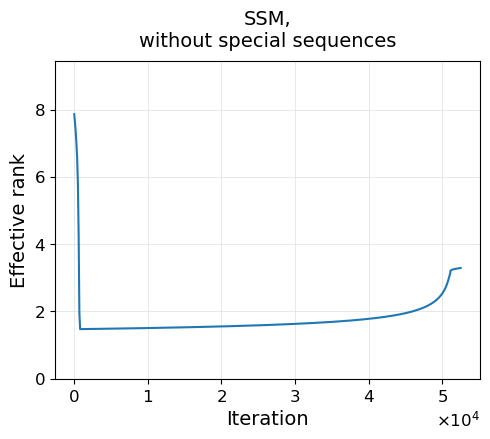

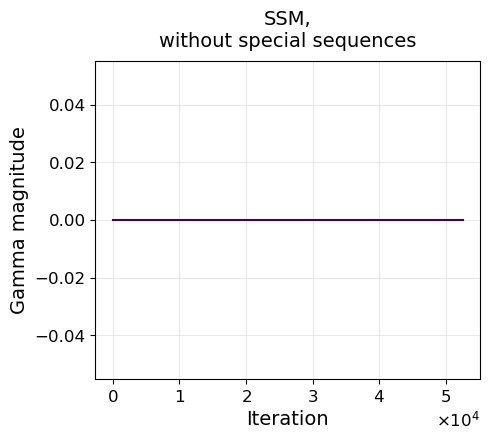

In [7]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim4=True, title=title)

## 8 baseline inputs, 10 special inputs

In [8]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [9]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 5.286596775054932
7 absolute largest EVs of A: [0.01008378 0.00915756 0.009155   0.00911377 0.00608313 0.00420095 0.00381499]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009999396279454231
7 absolute largest EVs of A: [1.0584935  0.41794673 0.41717225 0.40560022 0.12256567 0.0683733  0.06001198]
+-------------+
|Final results|
+-------------+
Train loss: 0.005821987986564636
7 absolute largest EVs of A: [1.0514578  0.47487625 0.4736896  0.45605674 0.09800611 0.0420844  0.0336187  0.02053969 0.00782119 0.00390639]
------------------------------------------------------------------------------------------------------
-------------------------------------------------------

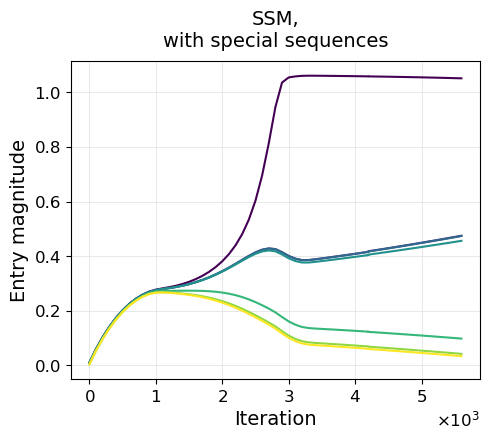

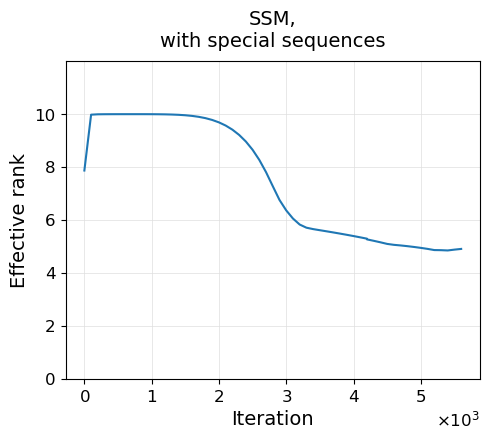

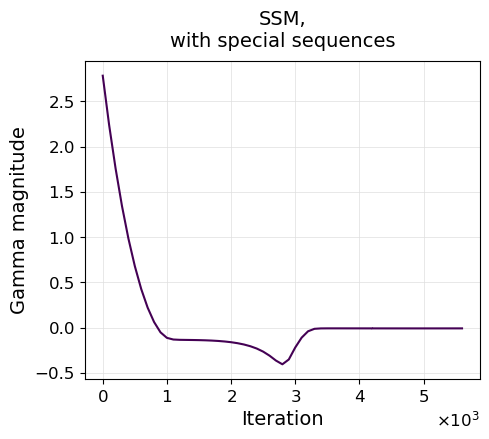

In [10]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim4=True, title=title)

# Length = 10, teacher state dim = 4, student state dim = 20

## Shared setup

In [11]:
seed = 1201
teacher_state_dim = 4
student_state_dim = 20
sd_A = 0.01
sd_B_C = 0.001
length = 10
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(3 * np.log10(1 / sd_A))

In [12]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
A[2, 2] = 0.5
A[3, 3] = 0.3
B[0, 0] = 1
B[0, 1] = 1
B[0, 2] = 1
B[0, 3] = 1
C[0, 0] = 1
C[1, 0] = 1
C[2, 0] = 1
C[3, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 8 baseline inputs, 0 special inputs

In [13]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
title = 'SSM,\nwithout special sequences'

In [14]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 22.831817626953125
7 absolute largest EVs of A: [0.02018796 0.02006402 0.02006279 0.02005784 0.01506086 0.01354757 0.01140294]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009933356195688248
7 absolute largest EVs of A: [1.0077422  0.6106194  0.6058074  0.5874244  0.04506981 0.03339006 0.02261656]
+-------------+
|Final results|
+-------------+
Train loss: 0.0031613875180482864
7 absolute largest EVs of A: [1.000709   0.642165   0.63443303 0.60575646 0.04421099 0.03290756 0.02239028 0.01460129 0.01031584 0.01029421 0.0097349  0.00864092 0.00822279 0.00788697 0.00603588 0.00547215 0.00403214 0.00167954
 0.00145828 0.00108592]
---------------------------------------------

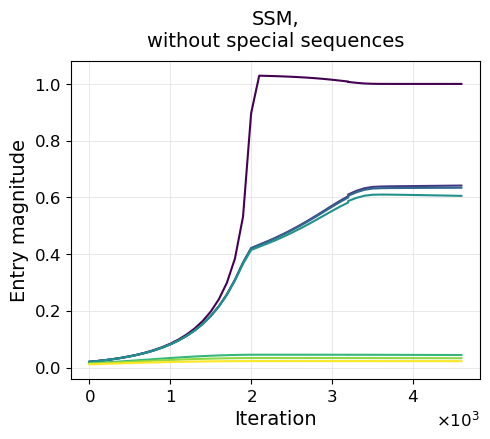

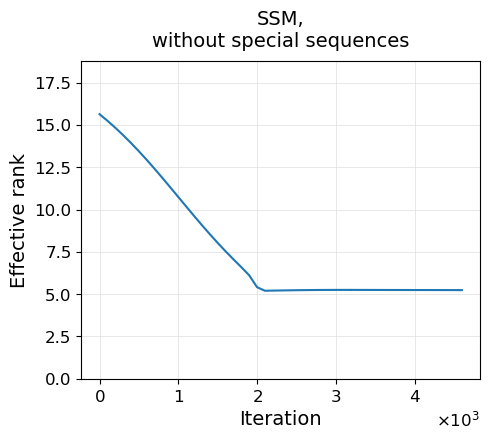

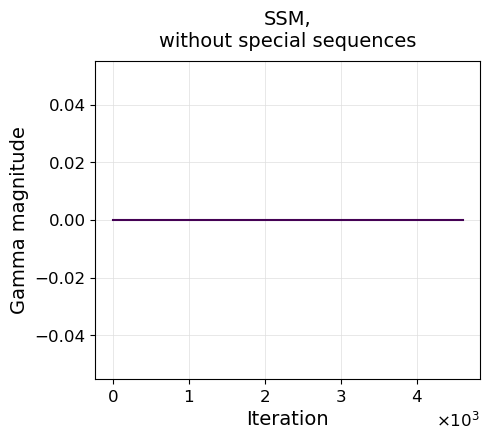

In [15]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim4=True, title=title)

## 8 baseline inputs, 10 special inputs

In [16]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [17]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 11.975160598754883
7 absolute largest EVs of A: [0.02018811 0.02006409 0.02006303 0.02005805 0.01506086 0.01354783 0.01140299]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009893490932881832
7 absolute largest EVs of A: [1.0002329  0.6309641  0.62975276 0.62437606 0.1015694  0.06887142 0.05237056]
+-------------+
|Final results|
+-------------+
Train loss: 0.0014107564929872751
7 absolute largest EVs of A: [1.0006257  0.6316423  0.629921   0.62231135 0.08925055 0.06349095 0.06153228 0.06037862 0.05823369 0.0485392  0.0416476  0.03901562 0.03062397 0.02913864 0.02730718 0.02521472 0.02259408 0.02022664
 0.02013739 0.00288292]
---------------------------------------------

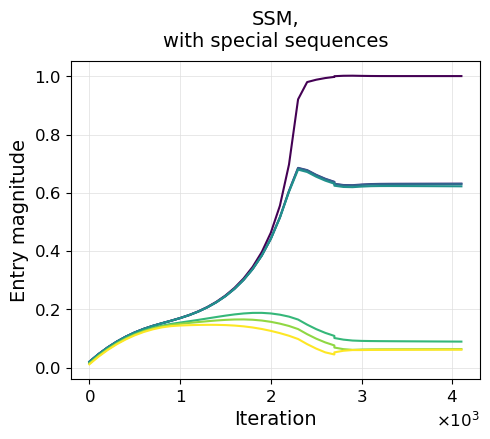

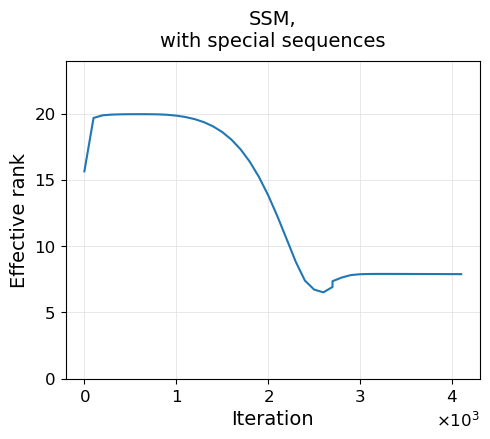

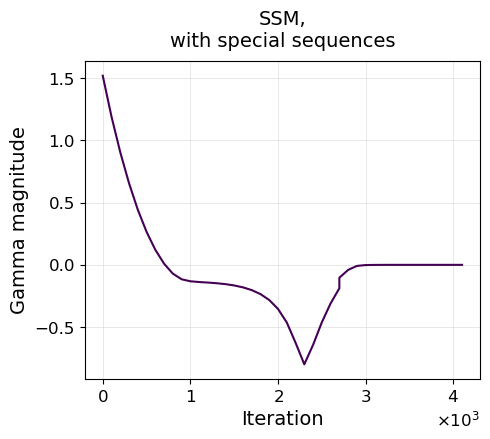

In [18]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim4=True, title=title)